In [124]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import keras
import matplotlib.pyplot as plt
import h5py
import itertools

from sklearn.metrics import precision_score, recall_score, roc_auc_score, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D, Input, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adamax
from tensorflow.keras.applications import VGG16, InceptionResNetV2, ResNet50, Xception
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall, AUC, TruePositives, TrueNegatives, FalsePositives, FalseNegatives
from keras_tuner.tuners import RandomSearch
import keras_tuner as kt
import kerastuner as kt
from glob import glob
from keras_tuner import HyperParameters
from kerastuner import HyperParameters
from tensorflow.keras.optimizers import legacy

print("Importações e dependencias adicionadas com sucesso.")

Importações e dependencias adicionadas com sucesso.


### DataPath

Contagem do número de ficheiros e quantidade de imagens em cada classe de doença de pele (**Urticaria**, **Psoriasis**, **Lupus**, **Dermatite**, **Melanoma**).

| Classe de Doença de Pele                                     | Conjunto de Treino | Conjunto de Teste |
|---------------------------------------------------------------|--------------------|-------------------|
| URTICARIA HIVES                                              | 416                | 53                |
| PSORIASIS PICTURES LICHEN PLANUS AND RELATED DISEASES        | 483                | 350               |
| LUPUS AND OTHER CONNECTIVE TISSUE DISEASES                   | 416                | 105               |
| ATOPIC DERMATITIS PHOTOS                                     | 483                | 123               |
| MELANOMA SKIN CANCER NEVI AND MOLES                          | 453                | 115               |

Total number of images in [URTICARIA HIVES] in train set: 1378
Total number of images in [PSORIASIS PICTURES LICHEN PLANUS AND RELATED DISEASES] in train set: 1378
Total number of images in [LUPUS AND OTHER CONNECTIVE TISSUE DISEASES] in train set: 1378
Total number of images in [ATOPIC DERMATITIS PHOTOS] in train set: 1378
Total number of images in [MELANOMA SKIN CANCER NEVI AND MOLES] in train set: 1378
Total number of images in [URTICARIA HIVES] in test set: 53
Total number of images in [PSORIASIS PICTURES LICHEN PLANUS AND RELATED DISEASES] in test set: 350
Total number of images in [LUPUS AND OTHER CONNECTIVE TISSUE DISEASES] in test set: 105
Total number of images in [ATOPIC DERMATITIS PHOTOS] in test set: 123
Total number of images in [MELANOMA SKIN CANCER NEVI AND MOLES] in test set: 115
Labels:  ['Urticaria Hives', 'Psoriasis pictures Lichen Planus and related diseases', 'Lupus and other Connective Tissue diseases', 'Atopic Dermatitis Photos', 'Melanoma Skin Cancer Nevi and Mo

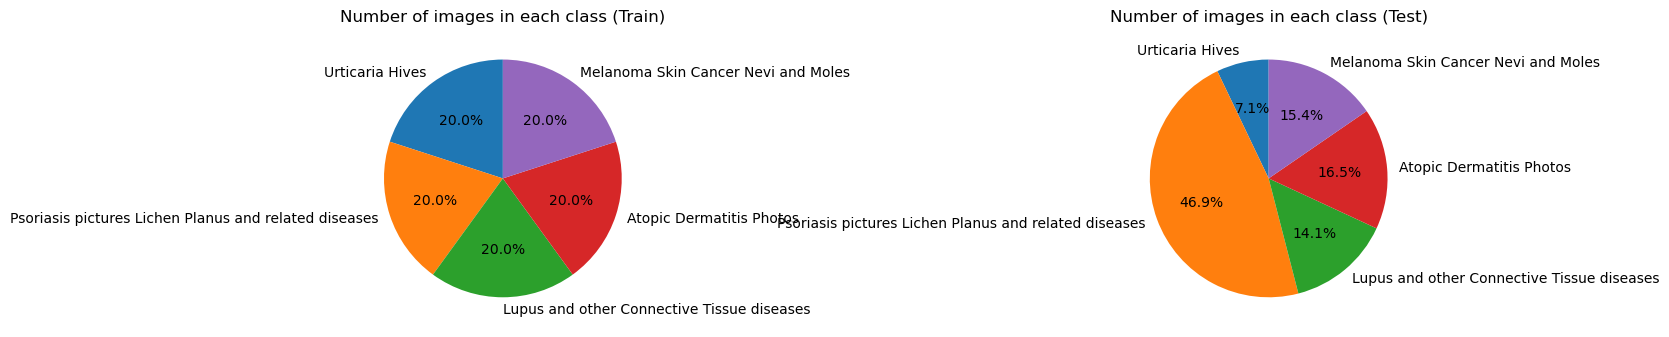

In [177]:
# Função para contar o número de arquivos 
def count_files(directory):
    return len([item for item in os.listdir(directory) if os.path.isfile(os.path.join(directory, item))])

# Caminhos dos diretórios de treino e teste
train_folder = '/Users/hugopereira/Github/Left4Health_3rdProject/ClassificationOfSkinDiseases/DataProcessed/train'
test_folder = '/Users/hugopereira/Github/Left4Health_3rdProject/ClassificationOfSkinDiseases/DataProcessed/test'

#train_folder= 'C:/Dev/DataProcessed/train'
#test_folder = 'C:/Dev/DataProcessed/test'


# Dicionários para armazenar o número de imagens em cada classe de doença de pele
train_diseases = {}
test_diseases = {}

# Função para contar o número de imagens em cada classe de doença de pele 
def count_images_in_folders(folder, diseases_dict):
    for label_folder in os.listdir(folder):
        label_path = os.path.join(folder, label_folder)
        if os.path.isdir(label_path):
            diseases_dict[label_folder] = count_files(label_path)

# Contagem do número de imagens em cada classe de doença de pele 
count_images_in_folders(train_folder, train_diseases)
count_images_in_folders(test_folder, test_diseases)

# Print do número de imagens em cada classe de doença de pele nos conjuntos de treino e teste
for label_folder, num_images in train_diseases.items():
    print(f'Total number of images in [{label_folder.upper()}] in train set: {num_images}')

for label_folder, num_images in test_diseases.items():
    print(f'Total number of images in [{label_folder.upper()}] in test set: {num_images}')

y=list(train_diseases.keys())
print("Labels: ",y)

# Plot do número de imagens em cada classe de doença de pele nos conjuntos de treino e teste 
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.pie(train_diseases.values(), labels=train_diseases.keys(), autopct='%1.1f%%', startangle=90)
plt.title('Number of images in each class (Train)')

plt.subplot(1, 2, 2)
plt.pie(test_diseases.values(), labels=test_diseases.keys(), autopct='%1.1f%%', startangle=90)
plt.title('Number of images in each class (Test)')

plt.tight_layout()
plt.show()

## Defnição de funções 

### Obtenção dos Dados de Treino, Validação e Teste

Definição de uma função para obter os dados de treino, validação e teste.

#### Funcionalidades Principais:

- **Função `get_data(train_folder, test_folder, image_size=(250, 250), batch_size=32)`:** Retorna geradores de dados para treino, validação e teste.
- **Pré-processamento dos Dados de Treino:** Utiliza `ImageDataGenerator` para aplicar transformações nos dados de treino, como redimensionamento, normalização e aumento de dados.
- **Divisão em Conjuntos de Treino e Validação:** Divide os dados de treino em conjuntos de treino e validação.
- **Pré-processamento dos Dados de Teste:** Aplica redimensionamento e normalização nos dados de teste.
- **Geradores de Dados:** Cria geradores de dados para treino, validação e teste, utilizando as configurações definidas.


In [185]:
def get_data(train_folder, test_folder, image_size=(250, 250), batch_size=64):
    # Data augmentation para o conjunto de treinamento
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2,  # Fixando a divisão em 80% treino e 20% validação
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=20,
        shear_range= 0.4,
        zoom_range=0.2,
        fill_mode='reflect'
    )

    # Carregar dados de treinamento e validação
    train_generator = train_datagen.flow_from_directory(
        train_folder,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',  # Define o subset como treinamento
        seed=10
    )

    validation_generator = train_datagen.flow_from_directory(
        train_folder,   
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',  # Define o subset como validação
        seed=10
    )

    # Obtendo o mapeamento de classes para índices
    class_indices = train_generator.class_indices

    # Invertendo o mapeamento para obter índices para classes
    indices_class = {v: k for k, v in class_indices.items()}

    # Inicializando um contador para cada classe
    class_counts_train = {class_name: 0 for class_name in indices_class.values()}

    # Iterando sobre o diretório de treinamento e contando o número de imagens em cada classe
    for class_name in class_counts_train.keys():
        class_folder = os.path.join(train_folder, class_name)
        num_images = len(os.listdir(class_folder))
        class_counts_train[class_name] = num_images

    # Data augmentation para o conjunto de teste
    test_datagen = ImageDataGenerator(rescale=1./255)

    # Carregar dados de teste
    test_generator = test_datagen.flow_from_directory(
        test_folder,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    # Obtendo o número de imagens por classe no conjunto de teste
    class_counts_test = {class_name: len(os.listdir(os.path.join(test_folder, class_name))) for class_name in class_counts_train.keys()}

    # Obtendo o número de imagens por classe no conjunto de validação
    class_counts_validation = {class_name: len(os.listdir(os.path.join(train_folder, class_name))) for class_name in class_counts_train.keys()}

    # Imprimindo o número de imagens para cada classe no conjunto de validação
    print("\nNúmero de imagens por classe no conjunto de validação:")
    for class_name, count in class_counts_validation.items():
        print(f"Classe: {class_name}, Número de Imagens: {count}")
    
    return train_generator, validation_generator, test_generator, class_counts_train, class_counts_test,class_counts_validation

train_generator, validation_generator, test_generator, class_counts_train, class_counts_test,class_counts_validation = get_data(train_folder, test_folder)

# Imprimindo o número de imagens para cada classe no conjunto de treinamento
print("Número de imagens por classe no conjunto de treinamento:")
for class_name, count in class_counts_train.items():
    print(f"Classe: {class_name}, Número de Imagens: {count}")

# Imprimindo o número de imagens para cada classe no conjunto de validação
print("\nNúmero de imagens por classe no conjunto de validação:")
for class_name, count in class_counts_validation.items():
    print(f"Classe: {class_name}, Número de Imagens: {count}")

# Imprimindo o número de imagens para cada classe no conjunto de teste
print("\nNúmero de imagens por classe no conjunto de teste:")
for class_name, count in class_counts_test.items():
    print(f"Classe: {class_name}, Número de Imagens: {count}")


Found 1803 images belonging to 5 classes.
Found 448 images belonging to 5 classes.
Found 746 images belonging to 5 classes.

Número de imagens por classe no conjunto de validação:
Classe: Atopic Dermatitis Photos, Número de Imagens: 483
Classe: Lupus and other Connective Tissue diseases, Número de Imagens: 416
Classe: Melanoma Skin Cancer Nevi and Moles, Número de Imagens: 453
Classe: Psoriasis pictures Lichen Planus and related diseases, Número de Imagens: 483
Classe: Urticaria Hives, Número de Imagens: 416
Número de imagens por classe no conjunto de treinamento:
Classe: Atopic Dermatitis Photos, Número de Imagens: 483
Classe: Lupus and other Connective Tissue diseases, Número de Imagens: 416
Classe: Melanoma Skin Cancer Nevi and Moles, Número de Imagens: 453
Classe: Psoriasis pictures Lichen Planus and related diseases, Número de Imagens: 483
Classe: Urticaria Hives, Número de Imagens: 416

Número de imagens por classe no conjunto de validação:
Classe: Atopic Dermatitis Photos, Númer

### Treino dos Modelos

Definição de uma função para treinar os modelos de classificação.

#### Funcionalidades Principais:

- **Função `train_model(model, train_generator, validation_generator, epochs)`:** Compila e treina o modelo de classificação.
- **Compilação do Modelo:** Utiliza o otimizador 'adam' e a função de perda 'categorical_crossentropy' para compilar o modelo. Além disso, utiliza a métrica de accuracy e precisão durante o treino.
- **Treino do Modelo:** Treina o modelo utilizando os geradores de dados de treino e validação, durante o número especificado de épocas.
- **Retorno do Modelo e Histórico:** Retorna o modelo treinado e o histórico de treino.


In [186]:
# Função para treinar os modelos
def train_model(model, train_generator, validation_generator, epochs):
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy', Precision()]
    )

    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs,
        verbose=1,
    )

    return model, history

### Avaliação dos Modelos

Definição de uma função para avaliar o desempenho dos modelos.

#### Funcionalidades Principais:

- **Função `evaluate_model(model, history, test_generator, test_folder)`:** Avalia o modelo de classificação.
- **Previsões:** Utiliza o modelo para fazer previsões sobre os dados de teste.
- **Conversão das Previsões para Rótulos:** Converte as previsões em rótulos para comparação com os rótulos verdadeiros.
- **Cálculo da Precisão, Recall e AUC:** Calcula a precisão, recall e AUC do modelo utilizando as previsões e os rótulos verdadeiros.
- **Visualização dos Resultados:** Plot da precisão, recall, AUC, bem como a precisão e perda de treino e validação em cada época.

In [187]:
# Função para avaliar os modelos
def evaluate_model(model, history, test_generator, test_folder): 
    # Prever
    y_pred = model.predict(test_generator)

    # Converter as previsões em rótulos
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = test_generator.classes

    # Calcular precisão, recall e exatidão
    precision = precision_score(y_true_labels, y_pred_labels, average='weighted', zero_division=0)
    recall = recall_score(y_true_labels, y_pred_labels, average='weighted', zero_division=0)
    accuracy = accuracy_score(y_true_labels, y_pred_labels)

    # O cálculo da AUC não é possível sem y_score (probabilidades de classe)
    # auc = roc_auc_score(y_true_labels, y_pred_labels, average='weighted', multi_class='ovr')

    # Gráfico da precisão e perda de treino e validação em cada época
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    
    # Gráfico da precisão de treino e validação do modelo
    plt.plot(history.history['accuracy'], label='Precisão de Treino')
    plt.plot(history.history['val_accuracy'], label='Precisão de Validação')
    plt.title('Precisão de Treino e Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Precisão')
    plt.legend()

    # Gráfico da perda de treino e validação em cada época
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Perda de Treino')
    plt.plot(history.history['val_loss'], label='Perda de Validação')
    plt.title('Perda de Treino e Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()

    plt.tight_layout()

    print("Precision:", precision)
    print("Recall:", recall)
    print("Accuracy:", accuracy)
    # print("AUC:", auc)

    plt.show()

### Guardar os Modelos

Definição de uma função para salvar os modelos treinados, juntamente com sua avaliação e histórico de treino.

#### Funcionalidades Principais:

- **Função `save_model(model, model_name, history, train_folder)`:** Salva o modelo treinado, sua avaliação e histórico de treinamento.
- **Criação de Pastas:** Cria pastas para salvar o modelo, a avaliação e o histórico, se não existirem.
- **Salvamento do Modelo:** Salva o modelo treinado em formato h5.
- **Avaliação do Modelo:** Avalia o modelo e salva a avaliação em uma figura.
- **Salvamento da Arquitetura do Modelo:** Plota e salva a arquitetura do modelo em uma imagem.
- **Salvamento do Histórico de Treinamento:** Salva o histórico de treinamento em um arquivo CSV.


In [79]:
# Função para guardar os modelos
def save_model(model, model_name, history, train_folder, test_folder, test_generator): 
    # Criar uma pasta para guardar os modelos se esta não existir
    if not os.path.exists('Modelos_Salvos'):
        os.mkdir('Modelos_Salvos')
    
    # Criar uma pasta para guardar o modelo se esta não existir
    if not os.path.exists('Modelos_Salvos/' + model_name):
        os.mkdir('Modelos_Salvos/' + model_name)
    
    # Guardar o modelo
    model.save('Saved_Models/'+ model_name +'/'+ model_name +'.h5')

    # Guardar a avaliação do modelo usando o gerador de teste
    evaluate_model(model, history, test_generator, test_folder)
    plt.savefig('Modelos_Salvos/' + model_name + '/' + model_name + '_avaliacao.png')

    # Guardar a arquitetura do modelo
    tf.keras.utils.plot_model(
        model,
        to_file='Modelos_Salvos/' + model_name + '/' + model_name + '.png',
        show_shapes=True,
        show_layer_names=True,
    )

    # Guardar o histórico do modelo num ficheiro CSV
    hist_df = pd.DataFrame(history.history)
    hist_csv_file = 'Modelos_Salvos/' + model_name + '/' + model_name + '_historico.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)

In [81]:
# Função para carregar o modelo e seu histórico
def load_model_and_history(model_name):
    # Verifica se o modelo existe
    model_path = 'Modelos_Salvos/' + model_name + '/' + model_name + '.h5'
    if not os.path.exists(model_path):
        print("O modelo especificado não existe.")
        return None, None
    
    # Carrega o modelo
    model = tf.keras.models.load_model(model_path)
    
    # Carrega o histórico
    history_path = 'Modelos_Salvos/' + model_name + '/' + model_name + '_historico.csv'
    if os.path.exists(history_path):
        history = pd.read_csv(history_path)
    else:
        print("O histórico do modelo não existe.")
        history = None
    
    return model, history

### Matrix de Confussão

Definição de uma função para mostrar a matriz de confussão associada a um dado modelo

#### Funcionalidades Principais:

- **Função `confussion_matrix(y_true_labels, y_pred_labels, test_generator)`:** Calcula a matriz de confusão, exibindo-a em um gráfico de calor. Além disso, mostra o relatório de classificação e os valores de verdadeiros positivos (TP), verdadeiros negativos (TN), falsos positivos (FP) e falsos negativos (FN).
  - **Cálculo da Matriz de Confusão:** Utiliza a função `confusion_matrix` para calcular a matriz de confusão com as etiquetas verdadeiras e preditas.
  - **Exibição da Matriz de Confusão:** Plota a matriz de confusão em um gráfico de calor, utilizando a biblioteca seaborn para uma melhor visualização.
  - **Relatório de Classificação:** Mostra um resumo do desempenho do modelo, incluindo métricas como precisão, recall e F1-score para cada classe.
  - **Cálculo dos Valores de TP, TN, FP, FN:** Calcula e exibe os valores de verdadeiros positivos, verdadeiros negativos, falsos positivos e falsos negativos.

In [82]:
def confussion_matrix(y_true_labels,y_pred_labels,test_generator):
    # Calcular a matriz de confusão
    cm = confusion_matrix(y_true_labels, y_pred_labels)

    # Exibir a matriz de confusão
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Calcular os verdadeiros positivos (TP), verdadeiros negativos (TN),
    # falsos positivos (FP) e falsos negativos (FN)
    TP = cm[1, 1]
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]

    # Exibir o relatório de classificação
    print("\nRelatório de Classificação:")
    print(classification_report(y_true_labels, y_pred_labels, target_names=test_generator.class_indices.keys()))

    # Exibir a tabela com os valores de TP, TN, FP, FN
    print("\nValores de TP, TN, FP, FN:")
    print("Verdadeiros Positivos:", TP)
    print("Verdadeiros Negativos:", TN)
    print("Falsos Positivos:", FP)
    print("Falsos Negativos:", FN)

## Modelos


### Compilação de Modelos COM TUNNING

Possui 2 metodos diferentes para arranjar os melhores hiperparametros:
    - **1.1** Metodo Random Search
    - **1.2** Metodo Grid Search

#### Random e Grid Search

In [95]:
#Definição do random search
def random_search(build_model, train_generator, test_generator, epochs, max_trials=5, executions_per_trial=1):
    tuner = RandomSearch(
        build_model,
        objective='val_accuracy',
        max_trials=max_trials,
        executions_per_trial=executions_per_trial,
        directory='test_tuner'
    )

    tuner.search(train_generator,
                 epochs=epochs,
                 validation_data=test_generator,
                 batch_size=32)

    best_model = tuner.get_best_models(num_models=1)[0]
    best

    history = best_model.fit(train_generator, validation_data=test_generator, epochs=epochs, verbose=1)

    # Obtendo o nome do modelo a partir da função de criação do modelo
    model_name = build_model.__name__ + '_randomsearch'
    
    # Salvando o modelo
    save_model(best_model,  model_name , history, train_folder, train_folder, test_generator)
    
    return best_model, history, model_name

In [60]:
#Definição do grid search
def grid_search(build_model, train_generator, test_generator, param_grid, epochs):
    best_accuracy = 0
    best_params = None
    best_model = None
    
    # Generate all combinations of parameters
    param_combinations = list(itertools.product(*param_grid.values()))
    
    for params in param_combinations:
        param_dict = dict(zip(param_grid.keys(), params))
        
        print("Training model with parameters:", param_dict)
        
        model = build_model(params=param_dict)
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        history = model.fit(train_generator, validation_data=test_generator, epochs=epochs, verbose=1)
        accuracy = history.history['val_accuracy'][-1]  # Use validation accuracy as the metric
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = param_dict
            best_model = model
                
    print("Best parameters:", best_params)
    print("Best validation accuracy:", best_accuracy)
    
    # Now you can train the final model with the best parameters
    final_model = build_model(params=best_params)
    final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    final_history = final_model.fit(train_generator, validation_data=test_generator, epochs=epochs, verbose=1)

   # Obtendo o nome do modelo a partir da função de criação do modelo
    model_name = build_model.__name__ + '_randomsearch'
    
    # Salvando o modelo
    save_model(best_model,  model_name , history, train_folder, train_folder, test_generator)
    
    return best_model, final_model, final_history, model_name


#### CNN 

In [96]:
# Definição da arquitetura da CNN
def CNN_model(hp=None, params=None):
    if hp is not None:
        # Se o objeto hp estiver presente, use-o para recuperar os hiperparâmetros
        filters = hp.Int('filters', min_value=16, max_value=128, step=16)
        kernel_size = hp.Choice('kernel_size', values=['3,3', '5,5'])  # Convertendo as tuplas em strings
        activation = hp.Choice('activation', values=['relu', 'tanh'])
        learning_rate = hp.Choice('learning_rate', values=[0.001, 0.01, 0.1])
        kernel_size = tuple(map(int, kernel_size.split(',')))  # Convertendo as strings de volta em tuplas
    elif params is not None:
        # Se o objeto params estiver presente, use-o para recuperar os hiperparâmetros
        filters = params.get('filters') if 'filters' in params else 64  # Valor padrão de 64 caso 'filters' não esteja presente em params
        kernel_size = params.get('kernel_size') if 'kernel_size' in params else '3,3'  # Valor padrão de '3,3' caso 'kernel_size' não esteja presente em params
        activation = params.get('activation') if 'activation' in params else 'relu'  # Valor padrão de 'relu' caso 'activation' não esteja presente em params
        learning_rate = params.get('learning_rate') if 'learning_rate' in params else 0.001  # Valor padrão de 0.001 caso 'learning_rate' não esteja presente em params
    else:
        raise ValueError("Ambos hp e params não podem ser None.")
    input_shape = (250, 250, 3)# Defina as dimensões corretas das imagens de entrad
    
    model = Sequential([
        Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, input_shape=input_shape, padding='same'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        Conv2D(filters=filters//2, kernel_size=kernel_size, activation=activation, padding='same'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        Conv2D(filters=filters//4, kernel_size=kernel_size, activation=activation, padding='same'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        GlobalAveragePooling2D(),
        Dense(units=64, activation='relu'),
        Dense(units=5, activation='softmax')
    ]) 
    
    opt = Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [99]:

#Utilização do Random Search
epochs=2
best_random_model, random_history, model_name= random_search(
    CNN_model, 
    train_generator, 
    test_generator, 
    epochs,
    max_trials=2,  # Altere o número de tentativas conforme necessário
    executions_per_trial=2
)

loaded_model_CNN_random, loaded_history_CNN_random = load_model_and_history('CNN_randomsearch')
if loaded_model_CNN_random is not None:
    print("Modelo carregado com sucesso!")
    print("Arquitetura do modelo:")
    loaded_model_CNN_random.summary()
    if loaded_history_CNN_random is not None:
        print("Histórico do modelo:")
        print(loaded_history_CNN_random.head())  # Visualizar as primeiras linhas do histórico

print("\nA fazer previsões no modelo...")
# Fazer previsões no conjunto de teste usando o modelo carregado
loaded_model_predictions = loaded_model_CNN_random.predict(test_generator)

# Converter as previsões em rótulos
y_pred_labels = np.argmax(loaded_model_predictions, axis=1)
y_true_labels = test_generator.classes

# Agora você pode chamar a função de matriz de confusão
confussion_matrix(y_true_labels, y_pred_labels, test_generator)

KeyError: '0 does not exist.'

In [78]:
#Utilização do Grid Search

epochs=10
# Define o grid de parâmetros para amostrar aleatoriamente
param_grid = {
    'filters': [32, 64, 128],
    'kernel_size': [(3, 3), (5, 5)],
    'activation': ['relu', 'tanh']
}

# Chamada da função de busca em grade de hiperparâmetros
best_grid_model, final_model, grid_history,model_name_grid = grid_search(CNN_model, train_generator, test_generator, param_grid,epochs)


Training model with parameters: {'filters': 32, 'kernel_size': (3, 3), 'activation': 'relu'}
Epoch 1/10


2024-04-09 20:23:49.413526: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - ETA: 0s - loss: 1.6104 - accuracy: 0.2135

2024-04-09 20:24:11.707427: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 25s 424ms/step - loss: 1.6104 - accuracy: 0.2135 - val_loss: 1.5726 - val_accuracy: 0.4692
Epoch 2/10
57/57 [==============================] - 25s 430ms/step - loss: 1.6066 - accuracy: 0.2102 - val_loss: 1.5863 - val_accuracy: 0.4504
Epoch 3/10
57/57 [==============================] - 24s 423ms/step - loss: 1.5992 - accuracy: 0.2280 - val_loss: 1.5539 - val_accuracy: 0.2386
Epoch 4/10
57/57 [==============================] - 23s 408ms/step - loss: 1.5934 - accuracy: 0.2341 - val_loss: 1.5368 - val_accuracy: 0.4611
Epoch 5/10
57/57 [==============================] - 23s 411ms/step - loss: 1.5563 - accuracy: 0.2884 - val_loss: 1.4721 - val_accuracy: 0.2869
Epoch 6/10
57/57 [==============================] - 24s 418ms/step - loss: 1.5077 - accuracy: 0.3372 - val_loss: 1.4222 - val_accuracy: 0.3633
Epoch 7/10
57/57 [==============================] - 23s 404ms/step - loss: 1.4975 - accuracy: 0.3516 - val_loss: 1.4327 - val_accuracy: 0.2761
Epoch 8/10

Training model with parameters: {'filters': 32, 'kernel_size': (3, 3), 'activation': 'tanh'}
Epoch 1/10


2024-04-09 20:27:47.268201: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - ETA: 0s - loss: 1.6115 - accuracy: 0.2113

2024-04-09 20:28:09.825544: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 25s 428ms/step - loss: 1.6115 - accuracy: 0.2113 - val_loss: 1.5589 - val_accuracy: 0.2855
Epoch 2/10
57/57 [==============================] - 24s 427ms/step - loss: 1.6080 - accuracy: 0.2091 - val_loss: 1.5524 - val_accuracy: 0.4692
Epoch 3/10
57/57 [==============================] - 24s 427ms/step - loss: 1.6057 - accuracy: 0.1963 - val_loss: 1.5751 - val_accuracy: 0.4651
Epoch 4/10
57/57 [==============================] - 25s 432ms/step - loss: 1.6026 - accuracy: 0.2512 - val_loss: 1.5620 - val_accuracy: 0.4182
Epoch 5/10
57/57 [==============================] - 24s 425ms/step - loss: 1.5899 - accuracy: 0.2535 - val_loss: 1.5376 - val_accuracy: 0.3231
Epoch 6/10
57/57 [==============================] - 25s 427ms/step - loss: 1.5821 - accuracy: 0.2640 - val_loss: 1.5422 - val_accuracy: 0.2708
Epoch 7/10
57/57 [==============================] - 25s 437ms/step - loss: 1.5679 - accuracy: 0.3017 - val_loss: 1.5416 - val_accuracy: 0.2399
Epoch 8/10

Training model with parameters: {'filters': 32, 'kernel_size': (5, 5), 'activation': 'relu'}
Epoch 1/10


2024-04-09 20:31:55.919567: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


40/57 [====================>.........] - ETA: 12s - loss: 1.6103 - accuracy: 0.2125

KeyboardInterrupt: 

Modelo carregado com sucesso!
Arquitetura do modelo:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 250, 250, 112)     3136      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 125, 125, 112)    0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 125, 125, 112)     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 56)      56504     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 56)       0         
 2D)                                                             
                                                                 
 dr

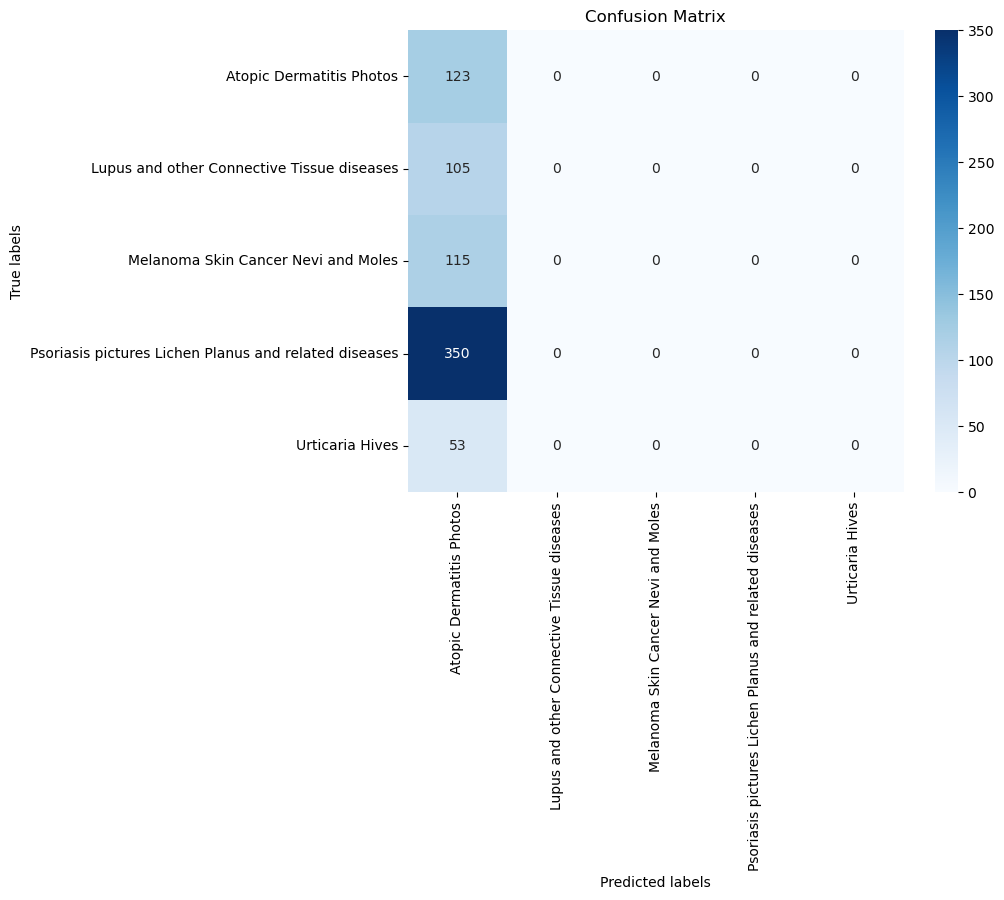


Relatório de Classificação:
                                                       precision    recall  f1-score   support

                             Atopic Dermatitis Photos       0.16      1.00      0.28       123
           Lupus and other Connective Tissue diseases       0.00      0.00      0.00       105
                  Melanoma Skin Cancer Nevi and Moles       0.00      0.00      0.00       115
Psoriasis pictures Lichen Planus and related diseases       0.00      0.00      0.00       350
                                      Urticaria Hives       0.00      0.00      0.00        53

                                             accuracy                           0.16       746
                                            macro avg       0.03      0.20      0.06       746
                                         weighted avg       0.03      0.16      0.05       746


Valores de TP, TN, FP, FN:
Verdadeiros Positivos: 0
Verdadeiros Negativos: 123
Falsos Positivos: 0
Falsos Negati

C:\Users\mariana\anaconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mariana\anaconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mariana\anaconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [30]:
#View of Grid Search Model

loaded_model_CNN_grid, loaded_history_CNN_grid= load_model_and_history(model_name_grid)
if loaded_model_CNN_random is not None:
    print("Modelo carregado com sucesso!")
    print("Arquitetura do modelo:")
    loaded_model_CNN_random.summary()
    if loaded_history_CNN_random is not None:
        print("Histórico do modelo:")
        print(loaded_history_CNN_random.head())  # Visualizar as primeiras linhas do histórico

print("\nA fazer previsões no modelo...")
# Fazer previsões no conjunto de teste usando o modelo carregado
loaded_model_predictions = loaded_model_CNN_random.predict(test_generator)

# Converter as previsões em rótulos
y_pred_labels = np.argmax(loaded_model_predictions, axis=1)
y_true_labels = test_generator.classes

# Agora você pode chamar a função de matriz de confusão
confussion_matrix(y_true_labels, y_pred_labels, test_generator)


#### VGG16

In [17]:
def VGG16_model(hp=None, params=None):
    if hp is not None:
        filters = hp.Int('filters', min_value=32, max_value=256, step=32)
        activation = hp.Choice('activation', values=['relu', 'tanh'])
        learning_rate = hp.Choice('learning_rate', values=[0.001, 0.01, 0.1])
    elif params is not None:
        filters = params.get('filters') if 'filters' in params else 64
        activation = params.get('activation') if 'activation' in params else 'relu'
        learning_rate = params.get('learning_rate') if 'learning_rate' in params else 0.001
    else:
        raise ValueError("Ambos hp e params não podem ser None.")
    
    input_shape = (250, 250, 3)
    resized_input = tf.keras.layers.experimental.preprocessing.Resizing(224, 224)(Input(shape=input_shape))
    
    vgg16_base = VGG16(include_top=False, weights=None, input_tensor=resized_input)
    vgg16_layer = vgg16_base.layers[-1].output
    
    x = GlobalAveragePooling2D()(vgg16_layer)
    x = Dense(units=128, activation=activation)(x)
    x = Dropout(rate=0.2)(x)
    
    output_layer = Dense(units=5, activation='softmax')(x)
    
    model = Model(inputs=resized_input, outputs=output_layer)
    
    opt = Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

Trial 2 Complete [00h 38m 46s]
val_accuracy: 0.46916890144348145

Best val_accuracy So Far: 0.46916890144348145
Total elapsed time: 01h 17m 18s


2024-04-09 01:30:08.848607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - ETA: 0s - loss: 1.6086 - accuracy: 0.2124 

2024-04-09 01:47:18.851504: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 1162s 21s/step - loss: 1.6086 - accuracy: 0.2124 - val_loss: 1.5863 - val_accuracy: 0.1649


2024-04-09 01:49:30.819083: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


24/24 [==============================] - 132s 5s/step
Precision: 0.027185202222397918
Recall: 0.1648793565683646
Accuracy: 0.1648793565683646


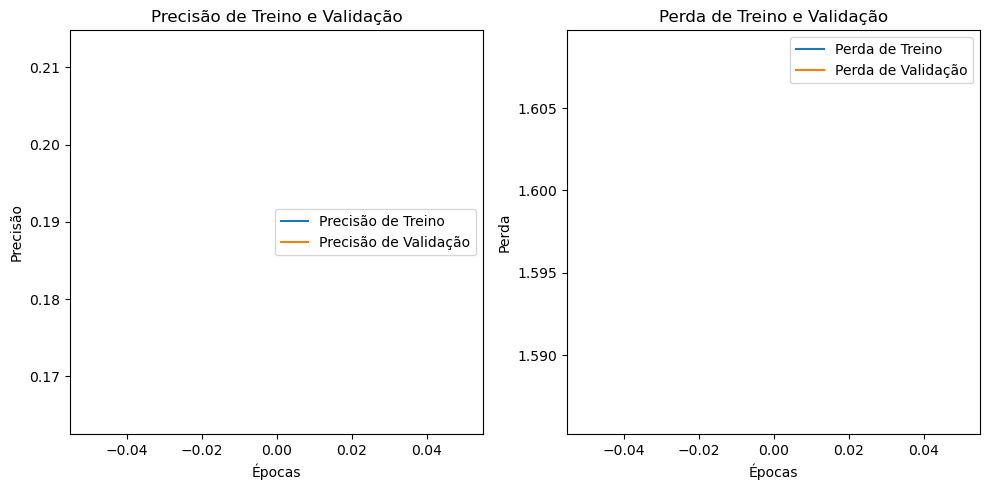

Modelo carregado com sucesso!
Arquitetura do modelo:
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_

<Figure size 640x480 with 0 Axes>

In [26]:
#Utilização do Random Search 
epochs = 1
best_random_model, random_history, model_name = random_hyperparameter_search(
    VGG16_model,  
    train_generator, 
    test_generator, 
    epochs,
    max_trials=2,  # Altere o número de tentativas conforme necessário
    executions_per_trial=2
)

loaded_model, loaded_history = load_model_and_history(model_name)
if loaded_model is not None:
    print("Modelo carregado com sucesso!")
    print("Arquitetura do modelo:")
    loaded_model.summary()
    if loaded_history is not None:
        print("Histórico do modelo:")
        print(loaded_history.head())  # Visualizar as primeiras linhas do histórico

In [22]:
#VIEW MODEL OF RANDOM SEARCH
loaded_model_VGG16, loaded_history_VGG16 = load_model_and_history('VGG16_model_randomsearch')
if loaded_model_VGG16 is not None:
    print("Modelo VGG16 carregado com sucesso!")
    print("Arquitetura do modelo:")
    loaded_model_VGG16.summary()
    if loaded_history_VGG16 is not None:
        print("Histórico do modelo:")
        print(loaded_history_VGG16.head())  # Visualizar as primeiras linhas do histórico

print("\nA fazer previsões no modelo VGG16...")
# Fazer previsões no conjunto de teste usando o modelo VGG16 carregado
loaded_model_predictions_VGG16 = loaded_model_VGG16.predict(test_generator)

# Converter as previsões em rótulos
y_pred_labels_VGG16 = np.argmax(loaded_model_predictions_VGG16, axis=1)
y_true_labels_VGG16 = test_generator.classes

# Agora você pode chamar a função de matriz de confusão
confussion_matrix(y_true_labels_VGG16, y_pred_labels_VGG16, test_generator)

O modelo especificado não existe.

A fazer previsões no modelo VGG16...


AttributeError: 'NoneType' object has no attribute 'predict'

In [ ]:
#Utilização do Grid Search

epochs=10
# Define o grid de parâmetros para amostrar aleatoriamente
param_grid = {
    'filters': [32, 64, 128, 256],  # Valores possíveis para o número de filtros
    'activation': ['relu', 'tanh'],  # Valores possíveis para a função de ativação
    'learning_rate': [0.001, 0.01, 0.1]  # Valores possíveis para a taxa de aprendizado
}

# Chamada da função de busca em grade de hiperparâmetros
best_grid_model, final_model, grid_history,model_name_grid = grid_search(VGG16_model, train_generator, test_generator, param_grid,epochs)


Training model with parameters: {'filters': 32, 'activation': 'relu', 'learning_rate': 0.001}
Epoch 1/10
57/57 [==============================] - 1552s 27s/step - loss: 1.6115 - accuracy: 0.2063 - val_loss: 1.5953 - val_accuracy: 0.4692
Epoch 2/10
57/57 [==============================] - 1540s 27s/step - loss: 1.6083 - accuracy: 0.2058 - val_loss: 1.5861 - val_accuracy: 0.4692
Epoch 3/10
57/57 [==============================] - 1538s 27s/step - loss: 1.6085 - accuracy: 0.2108 - val_loss: 1.5848 - val_accuracy: 0.4692
Epoch 4/10
16/57 [=======>......................] - ETA: 18:42 - loss: 1.6097 - accuracy: 0.2246

In [ ]:
#VIEW MODEL OF RANDOM SEARCH
loaded_model_VGG16, loaded_history_VGG16 = load_model_and_history('VGG16_gridsearch')
if loaded_model_VGG16 is not None:
    print("Modelo VGG16 carregado com sucesso!")
    print("Arquitetura do modelo:")
    loaded_model_VGG16.summary()
    if loaded_history_VGG16 is not None:
        print("Histórico do modelo:")
        print(loaded_history_VGG16.head())  # Visualizar as primeiras linhas do histórico

print("\nA fazer previsões no modelo VGG16...")
# Fazer previsões no conjunto de teste usando o modelo VGG16 carregado
loaded_model_predictions_VGG16 = loaded_model_VGG16.predict(test_generator)

# Converter as previsões em rótulos
y_pred_labels_VGG16 = np.argmax(loaded_model_predictions_VGG16, axis=1)
y_true_labels_VGG16 = test_generator.classes

# Agora você pode chamar a função de matriz de confusão
confussion_matrix(y_true_labels_VGG16, y_pred_labels_VGG16, test_generator)

#### Random e Grid Search Resnet

In [24]:
def ResNet_model(input_shape=(250, 250, 3), params=None):
    input_layer = Input(shape=input_shape)
    resized_input = tf.keras.layers.experimental.preprocessing.Resizing(224, 224)(input_layer)
    
    resnet_base = ResNet50(include_top=False, weights=None, input_tensor=resized_input)
    resnet_output = resnet_base.output
    
    x = GlobalAveragePooling2D()(resnet_output)
    
    # Verifica se há parâmetros definidos
    if params:
        units = params.get('units', 128)
        dropout = params.get('dropout', 0.2)
    else:
        units = 128
        dropout = 0.2
        
    x = Dense(units=units, activation='relu')(x)
    x = Dropout(rate=dropout)(x)
    
    output_layer = Dense(units=5, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    
    return model

In [ ]:
#Utilização do Random Search

epochs = 10
best_random_model, random_history, model_name = random_hyperparameter_search(
    ResNet_model,  # Use ResNet_model aqui
    train_generator, 
    test_generator, 
    epochs,
    max_trials=2,  # Altere o número de tentativas conforme necessário
    executions_per_trial=2
)


In [ ]:
#View Random Search
loaded_model_ResNet, loaded_history_ResNet = load_model_and_history('ResNet_randomsearch')
if loaded_model_ResNet is not None:
    print("Modelo ResNet carregado com sucesso!")
    print("Arquitetura do modelo:")
    loaded_model_ResNet.summary()
    if loaded_history_ResNet is not None:
        print("Histórico do modelo:")
        print(loaded_history_ResNet.head())  # Visualizar as primeiras linhas do histórico

print("\nA fazer previsões no modelo ResNet...")
# Fazer previsões no conjunto de teste usando o modelo ResNet carregado
loaded_model_predictions_ResNet = loaded_model_ResNet.predict(test_generator)

# Converter as previsões em rótulos
y_pred_labels_ResNet = np.argmax(loaded_model_predictions_ResNet, axis=1)
y_true_labels_ResNet = test_generator.classes

# Agora você pode chamar a função de matriz de confusão
confussion_matrix(y_true_labels_ResNet, y_pred_labels_ResNet, test_generator)


In [ ]:
#Utilização do Grid Search

param_grid = {
    'units': [64, 128, 256],
    'dropout': [0.1, 0.2, 0.3]
}
best_model_grid, final_model_grid, final_history_grid, model_name_grid = grid_search_resnet(ResNet_model, train_generator, test_generator, param_grid, epochs=10)

#### DOESNT WORK

Modelo CNN Grid Search carregado com sucesso!
Modelo CNN Random Search carregado com sucesso!
Melhor modelo: CNN Random Search
24/24 [==============================] - 11s 432ms/step


AttributeError: 'DataFrame' object has no attribute 'history'

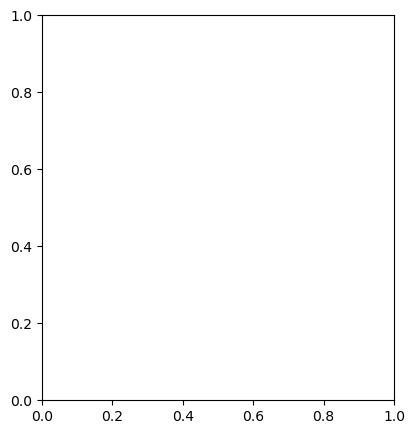

In [33]:
loaded_model_CNN_grid, loaded_history_CNN_grid= load_model_and_history(model_name_grid)
if loaded_model_CNN_random is not None:
    print("Modelo CNN Grid Search carregado com sucesso!")

loaded_model_CNN_random, loaded_history_CNN_random = load_model_and_history('CNN_randomsearch')
if loaded_model_CNN_random is not None:
    print("Modelo CNN Random Search carregado com sucesso!")

# Comparar a acurácia dos modelos
best_accuracy_grid = max(loaded_history_CNN_grid['val_accuracy'])
best_accuracy_random = max(loaded_history_CNN_random['val_accuracy'])

# Guardar apenas o melhor modelo
if best_accuracy_grid > best_accuracy_random:
    best_model = loaded_model_CNN_grid
    best_history = loaded_history_CNN_grid
    print("Melhor modelo: CNN Grid Search")
else:
    best_model = loaded_model_CNN_random
    best_history = loaded_history_CNN_random
    print("Melhor modelo: CNN Random Search")

# Avaliação do modelo
evaluate_model(best_model, best_history, test_generator, test_folder)

# Previsão usando o conjunto de teste
y_pred = best_model.predict(test_generator)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = test_generator.classes

# Matriz de confusão
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
print(conf_matrix)

# Salvar o melhor modelo
save_model(best_model, 'best_CNN_model', history, train_folder, test_folder, test_generator)

### Compilação de Modelos SEM TUNNING

#### CNN 2D

Found 1803 images belonging to 5 classes.
Found 448 images belonging to 5 classes.
Found 746 images belonging to 5 classes.

Número de imagens por classe no conjunto de validação:
Classe: Atopic Dermatitis Photos, Número de Imagens: 483
Classe: Lupus and other Connective Tissue diseases, Número de Imagens: 416
Classe: Melanoma Skin Cancer Nevi and Moles, Número de Imagens: 453
Classe: Psoriasis pictures Lichen Planus and related diseases, Número de Imagens: 483
Classe: Urticaria Hives, Número de Imagens: 416
Epoch 1/50


2024-04-12 03:10:46.432142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


29/29 [==============================] - ETA: 0s - loss: 1.6237 - accuracy: 0.2280 

2024-04-12 03:15:59.599620: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


29/29 [==============================] - 330s 11s/step - loss: 1.6237 - accuracy: 0.2280 - val_loss: 1.5975 - val_accuracy: 0.2500
Epoch 2/50
29/29 [==============================] - 316s 11s/step - loss: 1.5542 - accuracy: 0.3039 - val_loss: 1.5278 - val_accuracy: 0.3080
Epoch 3/50
29/29 [==============================] - 320s 11s/step - loss: 1.5339 - accuracy: 0.3239 - val_loss: 1.5856 - val_accuracy: 0.3036
Epoch 4/50
29/29 [==============================] - 317s 11s/step - loss: 1.5147 - accuracy: 0.3233 - val_loss: 1.5054 - val_accuracy: 0.3080
Epoch 5/50
29/29 [==============================] - 322s 11s/step - loss: 1.4657 - accuracy: 0.3267 - val_loss: 1.4956 - val_accuracy: 0.3371
Epoch 6/50
29/29 [==============================] - 331s 11s/step - loss: 1.4219 - accuracy: 0.3771 - val_loss: 1.4514 - val_accuracy: 0.3594
Epoch 7/50
29/29 [==============================] - 329s 11s/step - loss: 1.4198 - accuracy: 0.3638 - val_loss: 1.4562 - val_accuracy: 0.3839
Epoch 8/50
29/29 

2024-04-12 07:39:55.834399: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


12/12 [==============================] - 28s 2s/step
Precision: 0.5231428507282507
Recall: 0.42359249329758714
Accuracy: 0.42359249329758714


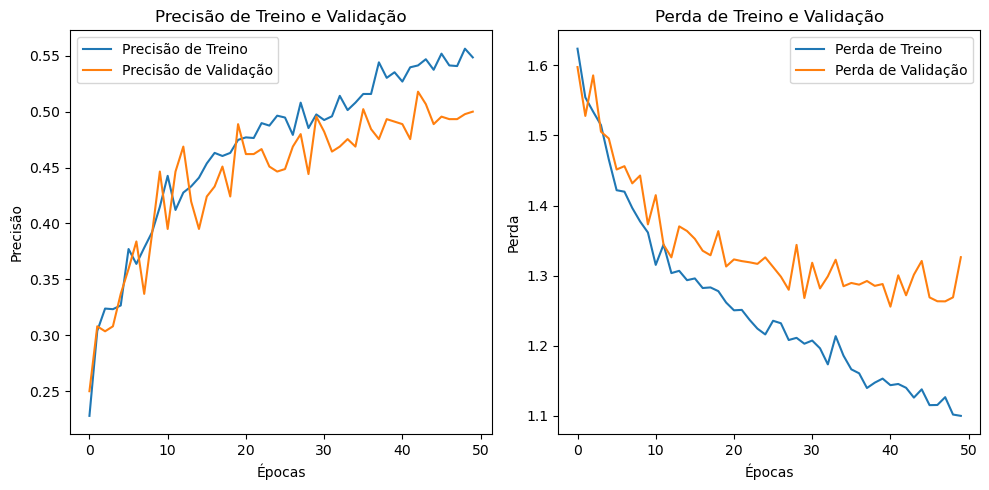

2024-04-12 07:40:24.400277: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


12/12 [==============================] - 28s 2s/step


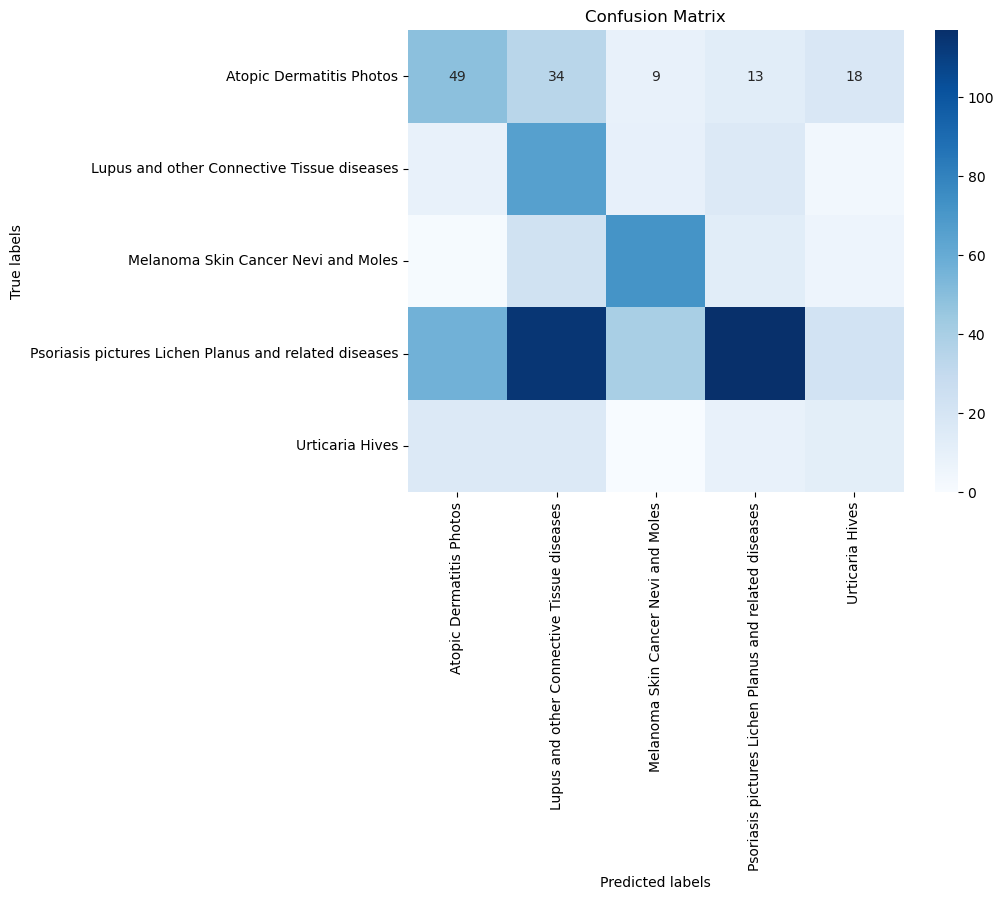


Relatório de Classificação:
                                                       precision    recall  f1-score   support

                             Atopic Dermatitis Photos       0.37      0.40      0.38       123
           Lupus and other Connective Tissue diseases       0.26      0.63      0.37       105
                  Melanoma Skin Cancer Nevi and Moles       0.55      0.63      0.59       115
Psoriasis pictures Lichen Planus and related diseases       0.70      0.33      0.45       350
                                      Urticaria Hives       0.19      0.23      0.21        53

                                             accuracy                           0.42       746
                                            macro avg       0.41      0.44      0.40       746
                                         weighted avg       0.52      0.42      0.43       746


Valores de TP, TN, FP, FN:
Verdadeiros Positivos: 66
Verdadeiros Negativos: 49
Falsos Positivos: 34
Falsos Negat

2024-04-12 07:40:53.618955: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,124,124,256]
	 [[{{node inputs}}]]
2024-04-12 07:40:53.624125: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,61,61,128]
	 [[{{node inputs}}]]
2024-04-12 07:40:53.628760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,29,29,64]
	 [[{{node inputs}}

INFO:tensorflow:Assets written to: Modelos_Salvos/CNN_model/CNN_model/assets


INFO:tensorflow:Assets written to: Modelos_Salvos/CNN_model/CNN_model/assets
2024-04-12 07:40:54.103219: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


12/12 [==============================] - 27s 2s/step
Precision: 0.5231428507282507
Recall: 0.42359249329758714
Accuracy: 0.42359249329758714


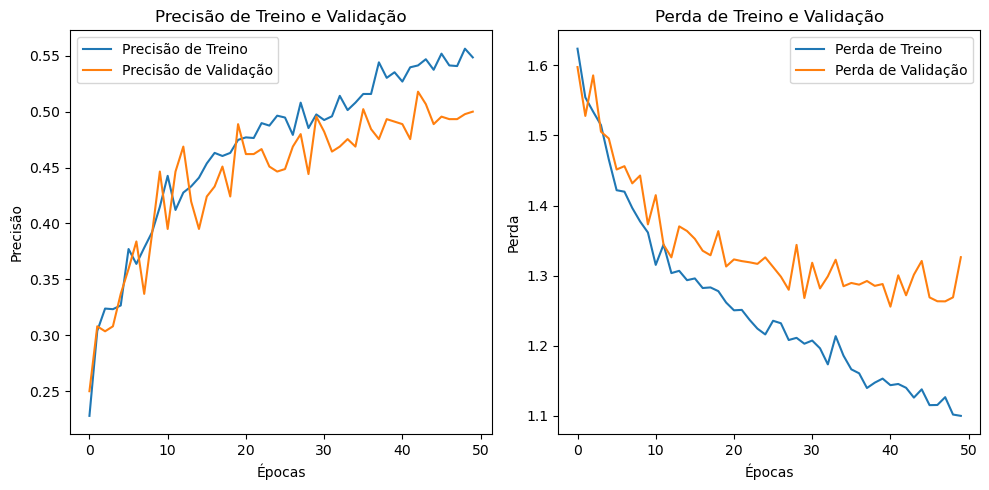

<Figure size 640x480 with 0 Axes>

In [188]:
# Definição da arquitetura da CNN
def Complex_CNN_model(input_shape=(250, 250, 3)):
    model = Sequential()
    model.add(Conv2D(256, (3, 3), activation="relu", input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    # Adicionando camadas convolucionais adicionais
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    # Flattening layer
    model.add(Flatten())

    # Adicionando camadas densas adicionais
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))  
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))

    # Camada de saída
    model.add(Dense(5, activation='softmax'))

    return model
# Execução do modelo CNN
def run_cnn_model(train_folder, test_folder, epochs=50
                 ):
    # Obtendo os dados
    train_generator, validation_generator, test_generator,_,_,_ = get_data(train_folder, test_folder)
    
    # Criação e compilação do modelo CNN
    model = CNN_model()
    model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
    
    # Treino do modelo
    history = model.fit(train_generator, validation_data=validation_generator, epochs=epochs, verbose=1)
    
    # Avaliação do modelo
    evaluate_model(model, history, test_generator, test_folder)

    #Verificcar se o y_pred e o y_pred_labels estao direitos
    # Prever usando o conjunto de teste
    y_pred = model.predict(test_generator)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = test_generator.classes
    
    confussion_matrix(y_true_labels,y_pred_labels,test_generator)

    # Guardar o modelo
    save_model(model, 'CNN_model', history, train_folder, test_folder, test_generator)

# Execução do modelo CNN
run_cnn_model(train_folder, test_folder)

In [ ]:
# Obter o modelo 
model = CNN_model()

# Sumário do modelo
model.summary()

#### ResNet50

Found 1803 images belonging to 5 classes.
Found 448 images belonging to 5 classes.
Found 746 images belonging to 5 classes.

Número de imagens por classe no conjunto de validação:
Classe: Atopic Dermatitis Photos, Número de Imagens: 483
Classe: Lupus and other Connective Tissue diseases, Número de Imagens: 416
Classe: Melanoma Skin Cancer Nevi and Moles, Número de Imagens: 453
Classe: Psoriasis pictures Lichen Planus and related diseases, Número de Imagens: 483
Classe: Urticaria Hives, Número de Imagens: 416
Epoch 1/50


2024-04-12 07:41:22.929059: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


29/29 [==============================] - ETA: 0s - loss: 2.9991 - accuracy: 0.2329

2024-04-12 07:45:05.515516: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


29/29 [==============================] - 237s 8s/step - loss: 2.9991 - accuracy: 0.2329 - val_loss: 2.8724 - val_accuracy: 0.1853
Epoch 2/50
29/29 [==============================] - 238s 8s/step - loss: 2.7756 - accuracy: 0.3184 - val_loss: 2.9078 - val_accuracy: 0.1853
Epoch 3/50
29/29 [==============================] - 237s 8s/step - loss: 2.6996 - accuracy: 0.3383 - val_loss: 3.0024 - val_accuracy: 0.1853
Epoch 4/50
29/29 [==============================] - 237s 8s/step - loss: 2.5866 - accuracy: 0.3649 - val_loss: 3.2914 - val_accuracy: 0.1853
Epoch 5/50
29/29 [==============================] - 239s 8s/step - loss: 2.5396 - accuracy: 0.3727 - val_loss: 3.3466 - val_accuracy: 0.1853
Epoch 6/50
29/29 [==============================] - 238s 8s/step - loss: 2.4901 - accuracy: 0.3744 - val_loss: 3.3017 - val_accuracy: 0.2165
Epoch 7/50
29/29 [==============================] - 238s 8s/step - loss: 2.4363 - accuracy: 0.4099 - val_loss: 3.4669 - val_accuracy: 0.1853
Epoch 8/50
29/29 [======

2024-04-12 11:22:36.328358: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


12/12 [==============================] - 24s 2s/step
Precision: 0.4582869125112902
Recall: 0.3820375335120643
Accuracy: 0.3820375335120643


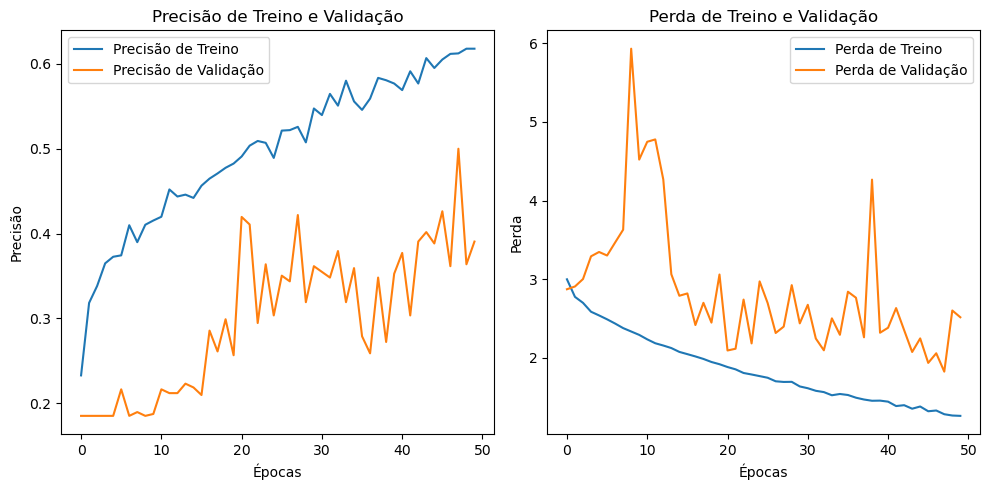

2024-04-12 11:23:00.169034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


12/12 [==============================] - 22s 2s/step


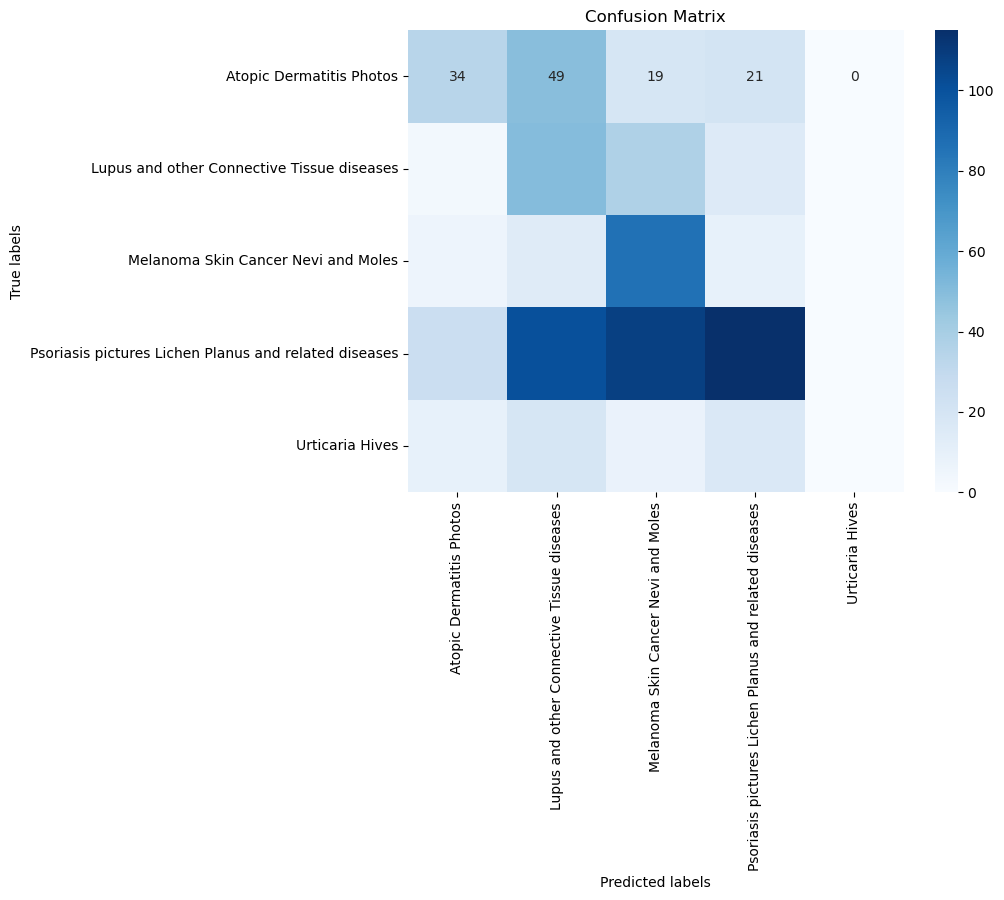


Relatório de Classificação:
                                                       precision    recall  f1-score   support

                             Atopic Dermatitis Photos       0.44      0.28      0.34       123
           Lupus and other Connective Tissue diseases       0.21      0.48      0.30       105
                  Melanoma Skin Cancer Nevi and Moles       0.33      0.75      0.46       115
Psoriasis pictures Lichen Planus and related diseases       0.65      0.33      0.44       350
                                      Urticaria Hives       0.00      0.00      0.00        53

                                             accuracy                           0.38       746
                                            macro avg       0.33      0.37      0.31       746
                                         weighted avg       0.46      0.38      0.37       746


Valores de TP, TN, FP, FN:
Verdadeiros Positivos: 50
Verdadeiros Negativos: 34
Falsos Positivos: 49
Falsos Negat

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2024-04-12 11:23:24.74290

INFO:tensorflow:Assets written to: Modelos_Salvos/ResNet_model/ResNet_model/assets


INFO:tensorflow:Assets written to: Modelos_Salvos/ResNet_model/ResNet_model/assets
2024-04-12 11:23:30.115225: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


12/12 [==============================] - 23s 2s/step
Precision: 0.4582869125112902
Recall: 0.3820375335120643
Accuracy: 0.3820375335120643


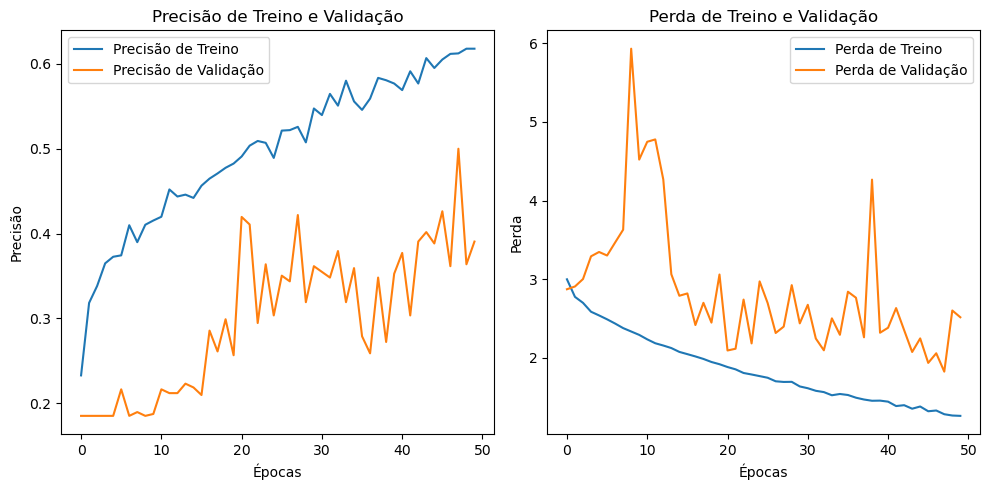

<Figure size 640x480 with 0 Axes>

In [189]:
# Definição da arquitetura da ResNet
def ResNet_model_complex(hp, input_shape=(250, 250, 3)):
    input_layer = Input(shape=input_shape)
    resized_input = tf.keras.layers.experimental.preprocessing.Resizing(224, 224)(input_layer)
    
    resnet_base = ResNet50(include_top=False, weights=None, input_tensor=resized_input)
    resnet_output = resnet_base.output
    
    # Mais camadas de convolução
    x = Conv2D(filters=128, kernel_size=3, activation='relu', padding='same')(resnet_output)
    x = MaxPooling2D(pool_size=2)(x)
    
    x = Conv2D(filters=256, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=2)(x)
    
    x = Conv2D(filters=512, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=2)(x)
    
    x = GlobalAveragePooling2D()(x)
    
    # Mais unidades em camadas densas
    x = Dense(units=hp.Int('units', min_value=256, max_value=1024, step=128), activation='relu')(x)
    x = Dropout(rate=hp.Float('dropout', min_value=0.3, max_value=0.6, step=0.1))(x)
    
    # Ajuste da taxa de dropout
    x = Dense(units=128, activation='relu', kernel_regularizer=regularizers.l2(0.3))(x)
    
    output_layer = Dense(units=5, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    
    return model
    
# Execução do modelo ResNet
def run_resnet_model(train_folder, test_folder, epochs=50):
    # Obtendo os dados
    train_generator, validation_generator, test_generator,_,_,_ = get_data(train_folder, test_folder)

    # Criação e compilação do modelo ResNet
    hp = HyperParameters()  
    model = ResNet_model(hp)  
    model.compile(optimizer=legacy.Adam(hp.Choice('learning_rate', values=[1e-4, 5e-5])),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    # Treino do modelo
    history = model.fit(train_generator, validation_data=validation_generator, epochs=epochs, verbose=1)
    
    # Avaliação do modelo
    evaluate_model(model, history, test_generator, test_folder)
    
    # Prever usando o conjunto de teste
    y_pred = model.predict(test_generator)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = test_generator.classes
    
    confussion_matrix(y_true_labels,y_pred_labels,test_generator)
    
    # Guardar o modelo
    save_model(model, 'ResNet_model', history, train_folder, test_folder, test_generator)

# Execução do modelo ResNet
run_resnet_model(train_folder, test_folder)

In [ ]:
# Obter o modelo 
model = ResNet_model()

# Sumário do modelo
model.summary()

#### VGG16

In [176]:
# Função para definir a arquitetura do modelo VGG16
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def VGG16_model(weights=None, input_shape=(250, 250, 3)):
    # Camada de entrada
    input_layer = Input(shape=input_shape)

    # Redimensionar as imagens de entrada para 224x224 para corresponder à forma de entrada do VGG16
    resized_input = tf.keras.layers.experimental.preprocessing.Resizing(224, 224)(input_layer)

    # Importar o modelo VGG16 da API do Keras
    vgg16_base = VGG16(include_top=False, weights=weights, input_tensor=resized_input)

    # Remover a última camada do VGG16, que é um GlobalAveragePooling2D
    vgg16_layer = vgg16_base.layers[-1].output

    # Adicionando mais camadas convolucionais
    x = Conv2D(filters=256, kernel_size=3, activation='relu', padding='same')(vgg16_layer)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=2)(x)
    
    # Mais unidades em camadas densas
    x = Flatten()(x)
    x = Dense(units=512, activation='relu')(x)  
    x = Dropout(rate=0.5)(x)  
    
    output_layer = Dense(units=5, activation='softmax')(x)

    # Modelo
    model = Model(inputs=input_layer, outputs=output_layer)

    return model

def run_vgg16_model(train_folder, test_folder, epochs=10):
    # Obtenção de dados
    train_generator, validation_generator, test_generator, _, _, _ = get_data(train_folder, test_folder)
    
    # Criação do modelo VGG16 complexo
    model = VGG16_model_complex()
    
    # Compilação do modelo
    optimizer = Adam(lr=0.0001)  
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    
    # Treinamento do modelo
    history = model.fit(train_generator, epochs=epochs, validation_data=validation_generator, callbacks=[early_stopping])
    
    # Avaliação do modelo
    evaluate_model(model, history, test_generator, test_folder)
    
    # Prever usando o conjunto de teste
    y_pred = model.predict(test_generator)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = test_generator.classes
    
    confussion_matrix(y_true_labels,y_pred_labels,test_generator)
    # Guardar o modelo
    save_model(model, 'VGG16_model', history, train_folder, test_folder, test_generator)

# Execução do modelo VGG16
run_vgg16_model(train_folder, test_folder)

Found 1803 images belonging to 5 classes.
Found 448 images belonging to 5 classes.
Found 746 images belonging to 5 classes.



Número de imagens por classe no conjunto de validação:
Classe: Atopic Dermatitis Photos, Número de Imagens: 483
Classe: Lupus and other Connective Tissue diseases, Número de Imagens: 416
Classe: Melanoma Skin Cancer Nevi and Moles, Número de Imagens: 453
Classe: Psoriasis pictures Lichen Planus and related diseases, Número de Imagens: 483
Classe: Urticaria Hives, Número de Imagens: 416
Epoch 1/10


2024-04-11 19:19:50.912448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - ETA: 0s - loss: 1.7493 - accuracy: 0.2196 

2024-04-11 19:29:38.590986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 630s 11s/step - loss: 1.7493 - accuracy: 0.2196 - val_loss: 1.6112 - val_accuracy: 0.2143
Epoch 2/10
57/57 [==============================] - 595s 10s/step - loss: 1.6101 - accuracy: 0.2113 - val_loss: 1.6091 - val_accuracy: 0.2143
Epoch 3/10
57/57 [==============================] - 611s 11s/step - loss: 1.6078 - accuracy: 0.2196 - val_loss: 1.6079 - val_accuracy: 0.2143
Epoch 4/10
57/57 [==============================] - 589s 10s/step - loss: 1.6092 - accuracy: 0.2052 - val_loss: 1.6078 - val_accuracy: 0.2143
Epoch 5/10
47/57 [=======================>......] - ETA: 1:37 - loss: 1.6089 - accuracy: 0.2174

KeyboardInterrupt: 

In [ ]:
# Obter o modelo
model = VGG16_model()

# Sumário do modelo
model.summary()

#### DenseNet

Found 1803 images belonging to 5 classes.
Found 448 images belonging to 5 classes.
Found 746 images belonging to 5 classes.

Número de imagens por classe no conjunto de validação:
Classe: Atopic Dermatitis Photos, Número de Imagens: 483
Classe: Lupus and other Connective Tissue diseases, Número de Imagens: 416
Classe: Melanoma Skin Cancer Nevi and Moles, Número de Imagens: 453
Classe: Psoriasis pictures Lichen Planus and related diseases, Número de Imagens: 483
Classe: Urticaria Hives, Número de Imagens: 416


Epoch 1/15


2024-04-12 11:23:55.731770: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


29/29 [==============================] - ETA: 0s - loss: 2.9904 - accuracy: 0.1947 

2024-04-12 11:30:16.546231: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


29/29 [==============================] - 398s 14s/step - loss: 2.9904 - accuracy: 0.1947 - val_loss: 244206827777048969216.0000 - val_accuracy: 0.1853
Epoch 2/15
29/29 [==============================] - 371s 13s/step - loss: 1.6381 - accuracy: 0.2851 - val_loss: 5416319488.0000 - val_accuracy: 0.2009
Epoch 3/15
29/29 [==============================] - 393s 14s/step - loss: 1.5541 - accuracy: 0.3245 - val_loss: 1614980.8750 - val_accuracy: 0.2143
Epoch 4/15
29/29 [==============================] - 383s 13s/step - loss: 1.4899 - accuracy: 0.3433 - val_loss: 17226.5059 - val_accuracy: 0.2009
Epoch 5/15
29/29 [==============================] - 368s 13s/step - loss: 1.4485 - accuracy: 0.3788 - val_loss: 256.4483 - val_accuracy: 0.1942
Epoch 6/15
29/29 [==============================] - 375s 13s/step - loss: 1.3864 - accuracy: 0.4032 - val_loss: 34.7708 - val_accuracy: 0.2076
Epoch 7/15
29/29 [==============================] - 372s 13s/step - loss: 1.3699 - accuracy: 0.4077 - val_loss: 31.06

2024-04-12 12:51:08.007852: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


12/12 [==============================] - 26s 2s/step
Precision: 0.4424243473360751
Recall: 0.28820375335120646
Accuracy: 0.28820375335120646


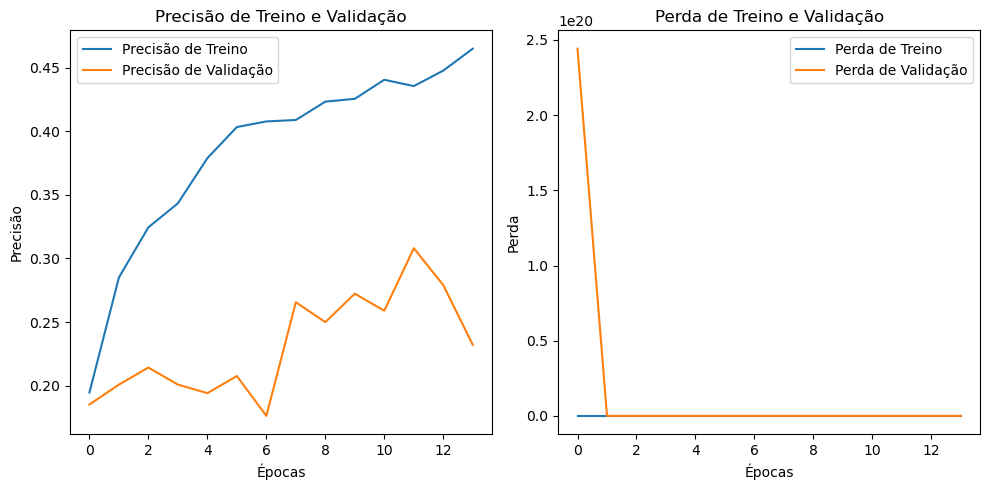

2024-04-12 12:51:34.224552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


12/12 [==============================] - 25s 2s/step


INFO:tensorflow:Assets written to: Modelos_Salvos/DenseNet_model/DenseNet_model/assets


INFO:tensorflow:Assets written to: Modelos_Salvos/DenseNet_model/DenseNet_model/assets
2024-04-12 12:52:15.740676: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


12/12 [==============================] - 25s 2s/step
Precision: 0.4424243473360751
Recall: 0.28820375335120646
Accuracy: 0.28820375335120646


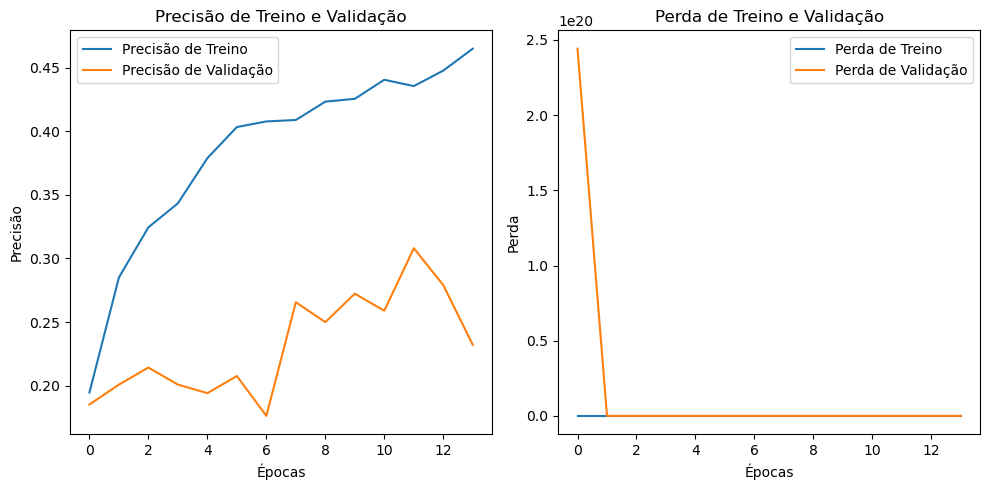

<Figure size 640x480 with 0 Axes>

In [190]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from sklearn.metrics import confusion_matrix

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def DenseNet_model(weights=None, input_shape=(250, 250, 3), num_classes=5):
    # Camada de entrada
    input_layer = Input(shape=input_shape)

    # Define the model architecture
    base_model = tf.keras.applications.densenet.DenseNet121(
        include_top=False,
        weights=weights,
        input_tensor=input_layer,
        input_shape=input_shape,
        pooling=None,
    )

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    output_layer = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)

    return model

def run_densenet_model(train_folder, test_folder, epochs=15):
    # Obtenção de dados
    train_generator, validation_generator, test_generator, class_counts_train, class_counts_test, class_counts_validation = get_data(train_folder, test_folder)
    
    # Número de classes
    num_classes = len(class_counts_train)

    # Criação e compilação do modelo DenseNet
    model = DenseNet_model(num_classes=num_classes)
    model.compile(optimizer=Adam(learning_rate=0.05), loss='categorical_crossentropy', metrics=['accuracy'])
   
    # Treino do modelo
    history = model.fit(train_generator, validation_data=validation_generator, epochs=epochs, verbose=1, callbacks=[EarlyStopping(patience=2, restore_best_weights=True)])
    
    # Avaliação do modelo
    evaluate_model(model, history, test_generator, test_folder)
    
    # Prever usando o conjunto de teste
    y_pred = model.predict(test_generator)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = test_generator.classes
    
    # Matriz de confusão
    confusion_matrix(y_true_labels, y_pred_labels)

    # Guardar o modelo
    save_model(model, 'DenseNet_model', history, train_folder, test_folder, test_generator)

# Execução do modelo DenseNet
run_densenet_model(train_folder, test_folder)

In [ ]:
# Obter o modelo
model = DenseNet_model()

# Sumário do modelo 
model.summary()

2024-04-12 12:55:52.010358: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2024-04-12 12:55:53.837914: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: Modelos_Salvos/CNN_model/CNN_model/assets


INFO:tensorflow:Assets written to: Modelos_Salvos/CNN_model/CNN_model/assets
2024-04-12 12:55:57.376918: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


12/12 [==============================] - 28s 2s/step
Precision: 0.06659231903798671
Recall: 0.20107238605898123
Accuracy: 0.20107238605898123


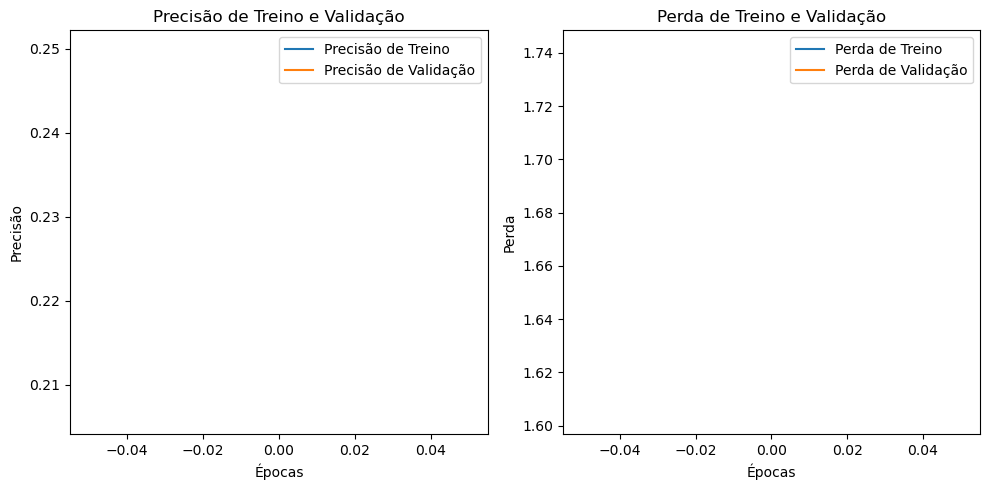

2024-04-12 12:56:29.010810: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2024-04-12 12:56:30.744238: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: Modelos_Salvos/ResNet_model/ResNet_model/assets


INFO:tensorflow:Assets written to: Modelos_Salvos/ResNet_model/ResNet_model/assets
2024-04-12 12:56:33.083247: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


12/12 [==============================] - 29s 2s/step
Precision: 0.06659231903798671
Recall: 0.20107238605898123
Accuracy: 0.20107238605898123


<Figure size 640x480 with 0 Axes>

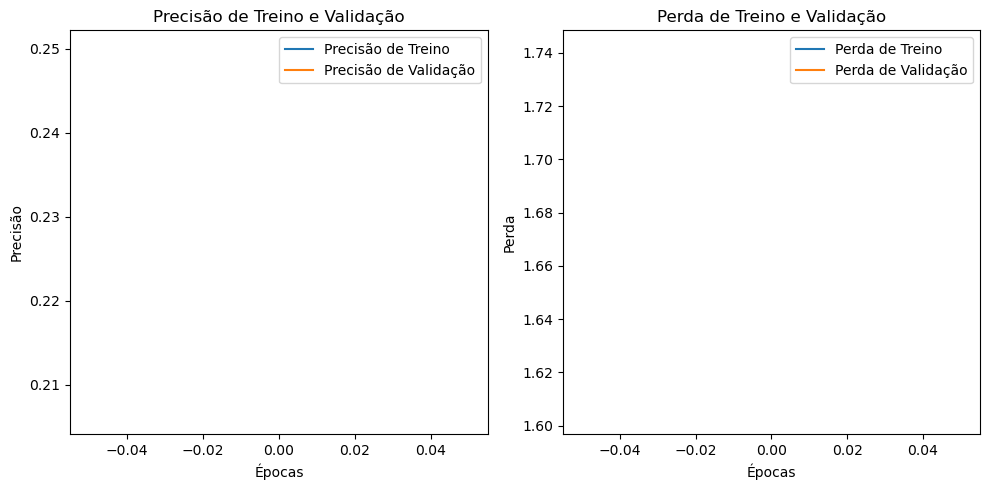

2024-04-12 12:57:04.911036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2024-04-12 12:57:07.236314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: Modelos_Salvos/DenseNet_model/DenseNet_model/assets


INFO:tensorflow:Assets written to: Modelos_Salvos/DenseNet_model/DenseNet_model/assets
2024-04-12 12:57:09.260222: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


12/12 [==============================] - 29s 2s/step
Precision: 0.06659231903798671
Recall: 0.20107238605898123
Accuracy: 0.20107238605898123


<Figure size 640x480 with 0 Axes>

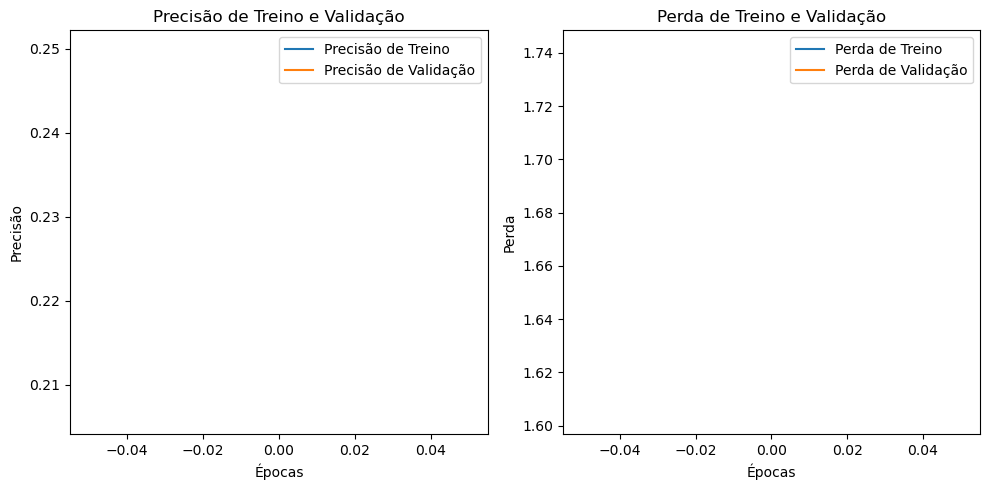

<Figure size 640x480 with 0 Axes>

In [191]:
    # Guardar o modelo
    save_model(model, 'CNN_model', history, train_folder, test_folder, test_generator)

    # Guardar o modelo
    save_model(model, 'ResNet_model', history, train_folder, test_folder, test_generator)

    # Guardar o modelo
    save_model(model, 'DenseNet_model', history, train_folder, test_folder, test_generator)